In [16]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import isingmodellight
from scipy import stats
import time

In [2]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [3]:
file_dir = 'E:\\Ising_model_results_daai'

In [4]:
def depytorch(t:torch.Tensor):
    return t.detach().cpu().numpy()

In [5]:
def make_histogram(name:str, values:torch.Tensor):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    axs.hist(  depytorch( values.flatten() )  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(name)
    axs.set_ylabel('count in bin')
    axs.set_title(f'distribution of {name}')
    plt.show()

In [6]:
def print_stats(name:str, values:torch.Tensor):
    values = values.flatten()
    quantile_cutoffs = torch.tensor([0.025, 0.5, 0.975], dtype=float_type, device=device)
    quantiles = torch.quantile(values, quantile_cutoffs)
    min_val = torch.min(values)
    max_val = torch.max(values)
    print(f'The distribution of {name} values has median {quantiles[1].item():.3g} with 95% CI [{quantiles[0].item():.3g}, {quantiles[2].item():.3g}] and range [{min_val.item():.3g}, {max_val.item():.3g}].')

In [7]:
def print_stats_too_big(name:str, values:torch.Tensor):
    values, _ = torch.sort( values.flatten() )
    num_values = values.numel()
    min_val = values[0]
    low_end = (num_values * 25)//1000
    low_val = values[low_end]
    print(f'lower quantile {low_end}, -1 and +1', values[low_end-1], values[low_end], values[low_end+1] )
    half_index = num_values//2
    print(f'half way point {half_index}, -1 and +1', values[half_index-1], values[half_index], values[half_index+1] )
    if (num_values % 2) == 0:
        med_val = (values[half_index] + values[half_index+1])/2
    else:
        med_val = values[half_index+1]
    high_end = (num_values * 975)//1000
    high_val = values[high_end]
    print(f'upper quantile {high_end}, -1 and +1', values[high_end-1], values[high_end], values[high_end+1] )
    max_val = values[-1]
    print(f'The distribution of {name} values has median {med_val:.3g} with 95% CI [{low_val:.3g}, {high_val:.3g}] and range [{min_val:.3g}, {max_val:.3g}].')

In [8]:
def make_scatter(xname:str, xvalues:torch.Tensor, yname:str, yvalues:torch.Tensor, save:bool=False, file_name:str=None):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    axs.scatter(  depytorch( xvalues.flatten() ), depytorch( yvalues.flatten() )  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(xname)
    axs.set_ylabel(yname)
    # axs.set_title(f'{xname} vs {yname}')
    plt.show()
    if save:
        plt.savefig(file_name)

In [9]:
def make_errorbar(xname:str, xvalues:torch.Tensor, yname:str, yvalues:torch.Tensor, yerrs:torch.Tensor, y_bounds=None, save:bool=False, file_name:str=None):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    x_flat = depytorch( xvalues.flatten() )
    y_flat = depytorch( yvalues.flatten() )
    axs.errorbar(  x=x_flat, y=y_flat, yerr=depytorch( yerrs.flatten() ), color='red', ecolor='blue'  )
    # axs.plot(x_flat, y_flat, color='red', label='mean', linewidth=10, fillstyle='full')
    if type(y_bounds) != type(None):
        axs.set_ylim(y_bounds)
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(xname)
    axs.set_ylabel(yname)
    # axs.legend()
    # axs.set_title(f'{xname} vs {yname}')
    plt.show()
    if save:
        plt.savefig(file_name)

In [10]:
def print_proportions_of_variance_explained(variable_name:str, explainer_name:str, values:torch.Tensor, dim):
    mean_of_variance = torch.mean( torch.var(values, dim=dim) )
    variance_of_mean = torch.var( torch.mean(values, dim=dim) )
    total_variance = torch.var(values)
    proportion_unexplained = mean_of_variance/total_variance
    proportion_explained = variance_of_mean/total_variance
    F_stat = variance_of_mean/mean_of_variance
    proportion_sum = proportion_explained + proportion_unexplained
    print(f'proportion of variance of {variable_name} explained by {explainer_name} = {variance_of_mean:.3g}/{total_variance:.3g} = {proportion_explained:.3g}. Proportion unexplained = {mean_of_variance:.3g}/{total_variance:.3g} = {proportion_unexplained:.3g}. F-stat = {F_stat:.3g}. Explained + unexplained = {proportion_sum:.3g}.')

In [11]:
def make_histogram_pair(values1:torch.Tensor, values2:torch.Tensor, label1:str, label2:str, xlabel:str):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    values1_flat = values1.flatten().detach().cpu().numpy()
    values2_flat = values2.flatten().detach().cpu().numpy()
    axs.hist( values1_flat, label=label1 )
    axs.hist( values2_flat, label=label2 )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(xlabel)
    axs.set_ylabel('count in bin')
    # axs.set_title(f'distribution of {xlabel}')
    axs.legend()
    plt.show()
    print( stats.mannwhitneyu(x=values1_flat, y=values2_flat) )

In [12]:
def show_square(values:torch.Tensor):
    fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(10, 10) )
    cbax = axs.imshow( depytorch(values) )
    fig.colorbar(cbax, shrink=0.8)

In [13]:
training_index_start = 0
training_index_end = 669

In [13]:
data_mean_state_file = os.path.join(file_dir, 'mean_state_all_unit_scale.pt')
data_mean_state = torch.load(data_mean_state_file)[:,training_index_start:training_index_end,:]
print( data_mean_state.size() )

torch.Size([4, 669, 360])


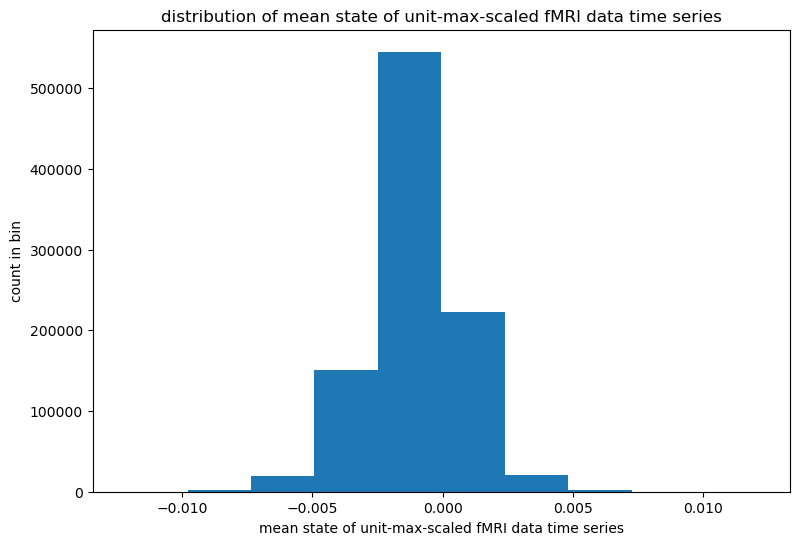

The distribution of mean state of unit-max-scaled fMRI data time series values has median -0.000958 with 95% CI [-0.00477, 0.00234] and range [-0.0122, 0.0121].


In [14]:
name = 'mean state of unit-max-scaled fMRI data time series'
values = data_mean_state
make_histogram(name=name, values=values)
# print_stats_too_big(name=name, values=values)
print_stats(name=name, values=values)

In [14]:
data_mean_state_product_file = os.path.join(file_dir, 'mean_state_product_all_unit_scale.pt')
data_mean_state_product = torch.load(data_mean_state_product_file)[:,training_index_start:training_index_end,:]
print( data_mean_state_product.size() )

torch.Size([4, 669, 360, 360])


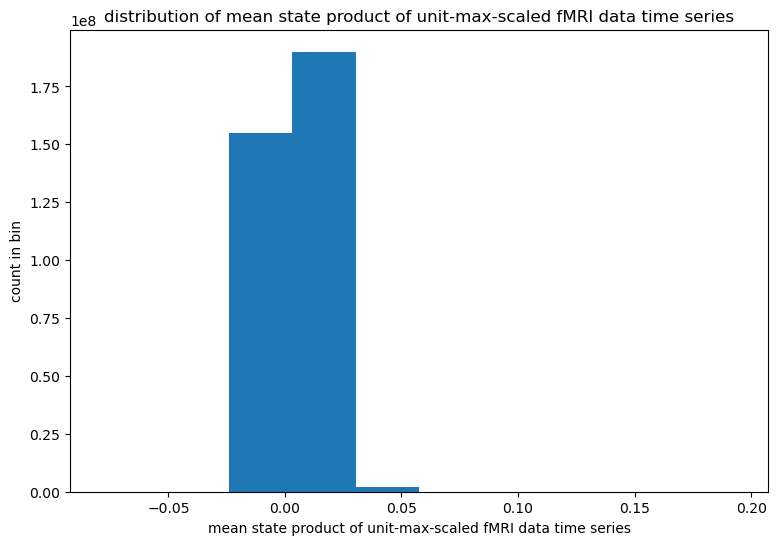

lower quantile 8670240, -1 and +1 tensor(-0.0013, device='cuda:0') tensor(-0.0013, device='cuda:0') tensor(-0.0013, device='cuda:0')
half way point 173404800, -1 and +1 tensor(0.0037, device='cuda:0') tensor(0.0037, device='cuda:0') tensor(0.0037, device='cuda:0')
upper quantile 338139360, -1 and +1 tensor(0.0208, device='cuda:0') tensor(0.0208, device='cuda:0') tensor(0.0208, device='cuda:0')
The distribution of mean state product of unit-max-scaled fMRI data time series values has median 0.00368 with 95% CI [-0.00131, 0.0208] and range [-0.0785, 0.194].


In [15]:
name = 'mean state product of unit-max-scaled fMRI data time series'
values = data_mean_state_product
make_histogram(name=name, values=values)
print_stats_too_big(name=name, values=values)
# print_stats(name=name, values=values)

In [17]:
num_nodes = data_mean_state.size(dim=-1)
triu_indices = torch.triu_indices(row=num_nodes, col=num_nodes, offset=1, dtype=int_type, device=device)
triu_rows = triu_indices[0]
triu_cols = triu_indices[1]

In [18]:
sample_product_triu = data_mean_state_product[0,0,:]
sample_product_square = torch.zeros( size=(num_nodes, num_nodes), dtype=float_type, device=device )
sample_product_square[triu_rows, triu_cols] = sample_product_triu
sample_product_square[triu_cols, triu_rows] = sample_product_triu

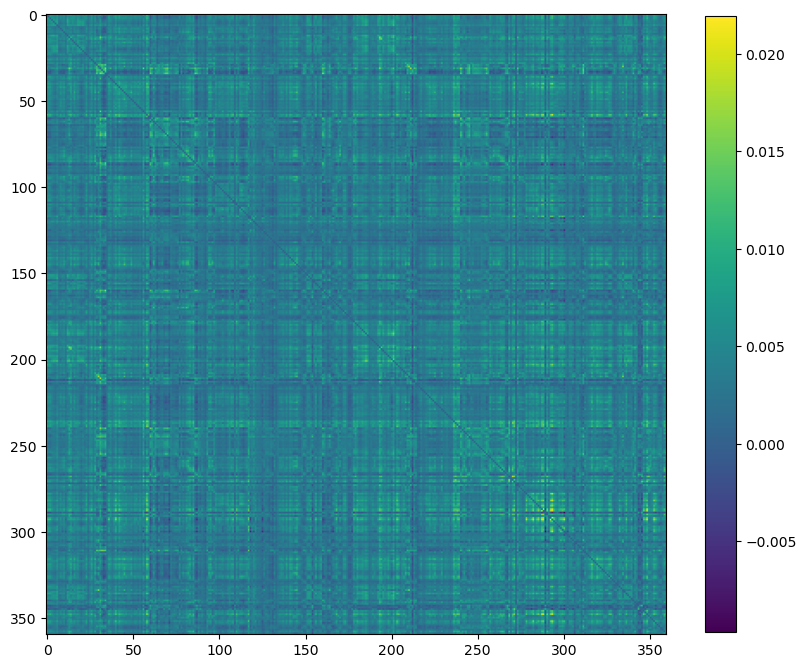

In [19]:
show_square(sample_product_square)

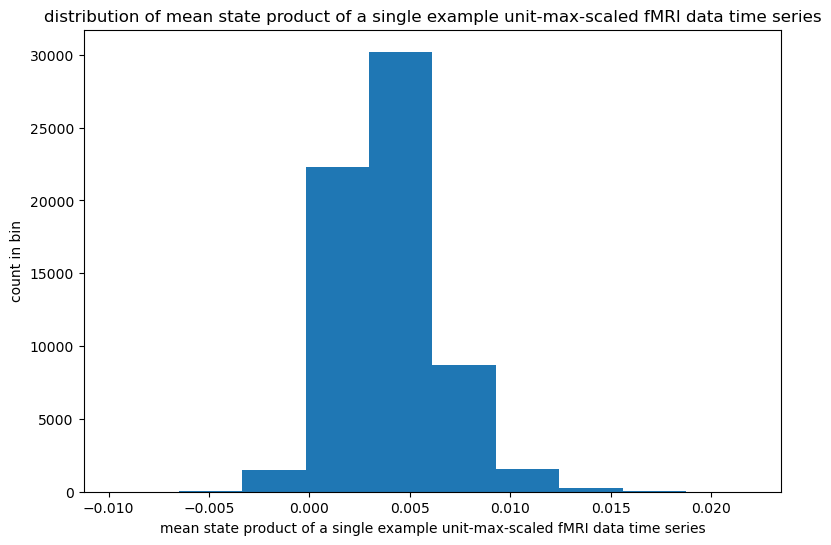

The distribution of mean state product of a single example unit-max-scaled fMRI data time series values has median 0.00364 with 95% CI [-0.000168, 0.00953] and range [-0.00967, 0.0219].


In [29]:
name = 'mean state product of a single example unit-max-scaled fMRI data time series'
values = sample_product_triu
make_histogram(name=name, values=values)
print_stats(name=name, values=values)

In [20]:
sample_mean = data_mean_state[0,0,:]
sample_cov = sample_product_square - sample_mean[:,None] * sample_mean[None,:]

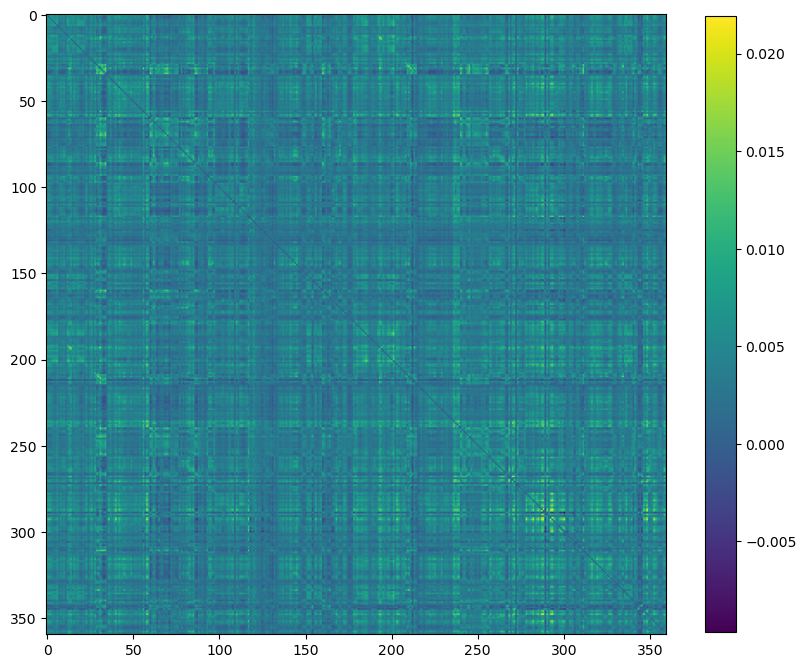

In [21]:
show_square(sample_cov)

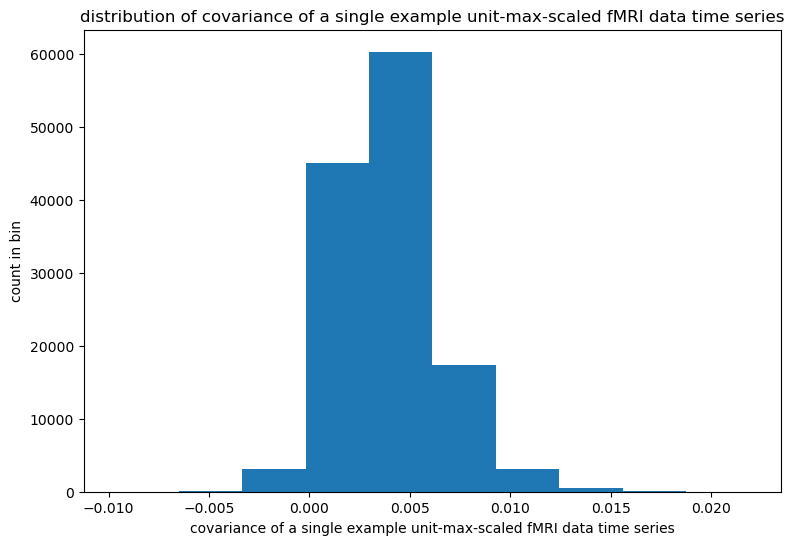

The distribution of covariance of a single example unit-max-scaled fMRI data time series values has median 0.00362 with 95% CI [-0.000167, 0.00951] and range [-0.00967, 0.0219].


In [28]:
name = 'covariance of a single example unit-max-scaled fMRI data time series'
values = sample_cov
make_histogram(name=name, values=values)
print_stats(name=name, values=values)

In [22]:
sample_inv_cov = torch.linalg.inv(sample_cov)

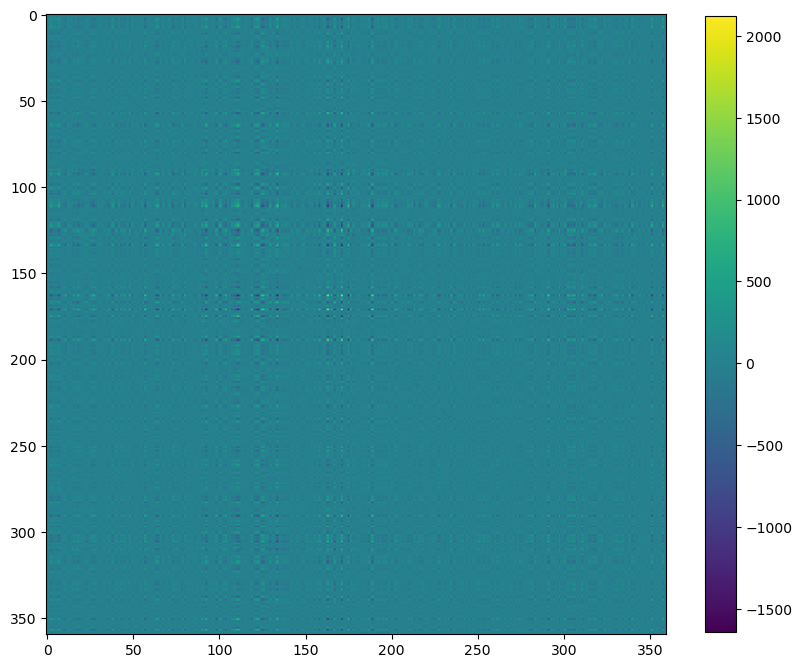

In [23]:
show_square(sample_inv_cov)

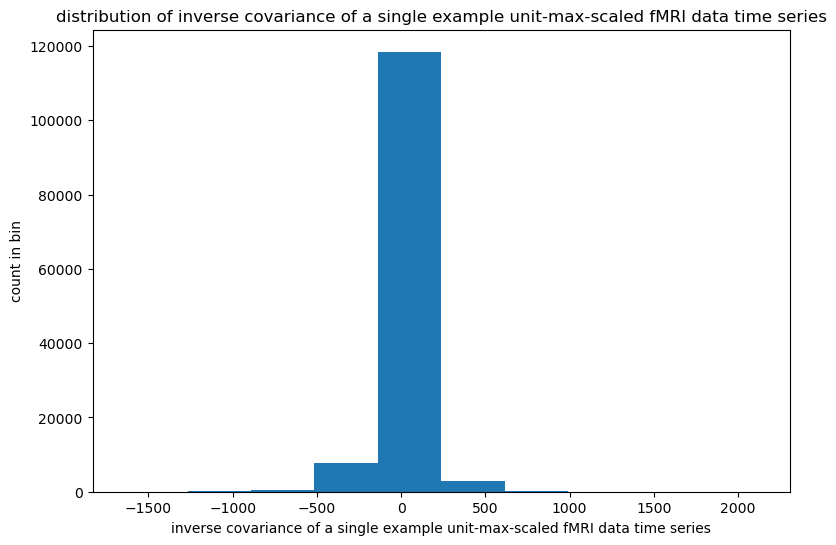

The distribution of inverse covariance of a single example unit-max-scaled fMRI data time series values has median -0.132 with 95% CI [-232, 233] and range [-1.64e+03, 2.12e+03].


In [30]:
name = 'inverse covariance of a single example unit-max-scaled fMRI data time series'
values = sample_inv_cov
make_histogram(name=name, values=values)
print_stats(name=name, values=values)

In [59]:
num_steps = 1200
state = torch.ones_like(sample_mean)
J = sample_inv_cov
h = sample_mean
beta = 10e-7
choice_ts = torch.rand( size=(num_nodes, num_steps), dtype=state.dtype, device=state.device ).log()/(-2*beta)
start_time = time.time()
print('starting sim...')
for t in range(num_steps):
    for n in range(num_nodes):
        state[n] *= (   1 - 2*(  choice_ts[n,t] > state[n]*( h[n] + torch.dot(J[n,:],state) )  ).float()   )
    choice_ts[:,t] = state
print(f'done, time {time.time()-start_time:.3f} seconds')

starting sim...
done, time 55.582 seconds


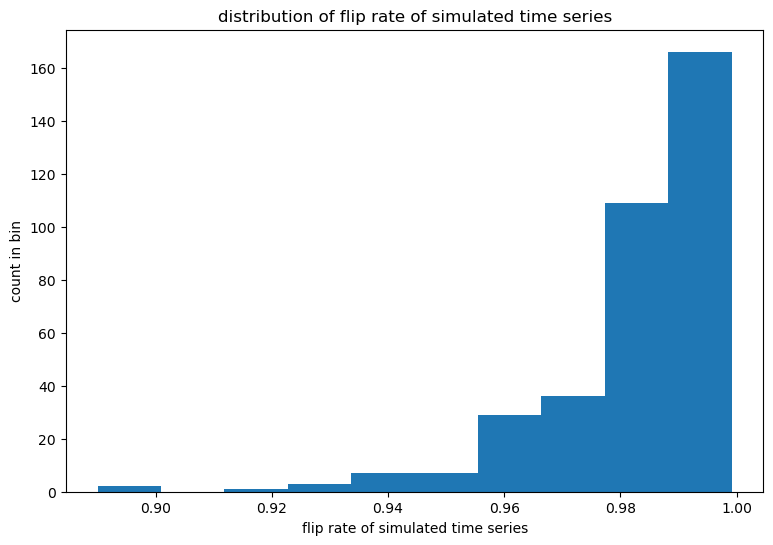

The distribution of flip rate of simulated time series values has median 0.987 with 95% CI [0.942, 0.998] and range [0.89, 0.999].


In [68]:
flip_rate = torch.count_nonzero(choice_ts[:,1:] != choice_ts[:,:-1], dim=-1)/num_steps
name = 'flip rate of simulated time series'
values = flip_rate.float()
make_histogram(name=name, values=values)
print_stats(name=name, values=values)

torch.Size([360, 360])


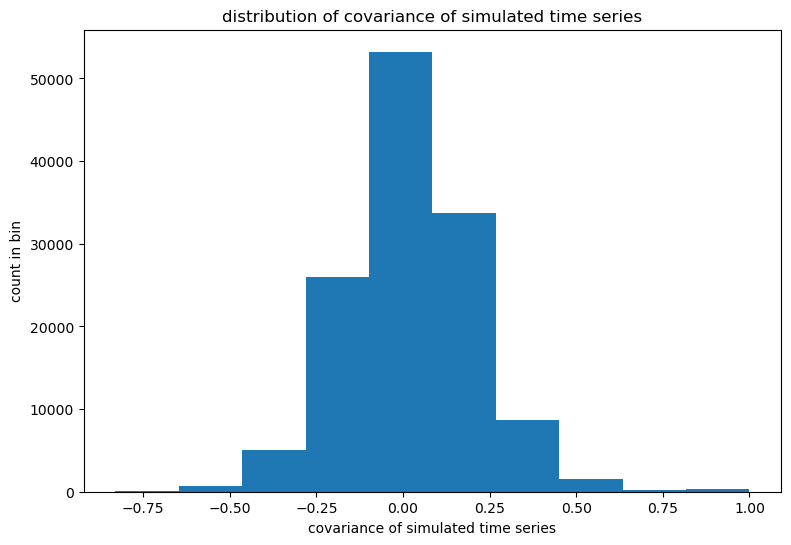

The distribution of covariance of simulated time series values has median 0.0183 with 95% CI [-0.335, 0.403] and range [-0.83, 1].


In [69]:
sim_mean = choice_ts.mean(dim=-1)
sim_mean_product = torch.matmul( choice_ts, choice_ts.transpose(dim0=0, dim1=1) )/num_steps
print( sim_mean_product.size() )
sim_cov = sim_mean_product - sim_mean[:,None] * sim_mean[None,:]
name = 'covariance of simulated time series'
values = sim_cov
make_histogram(name=name, values=values)
print_stats(name=name, values=values)

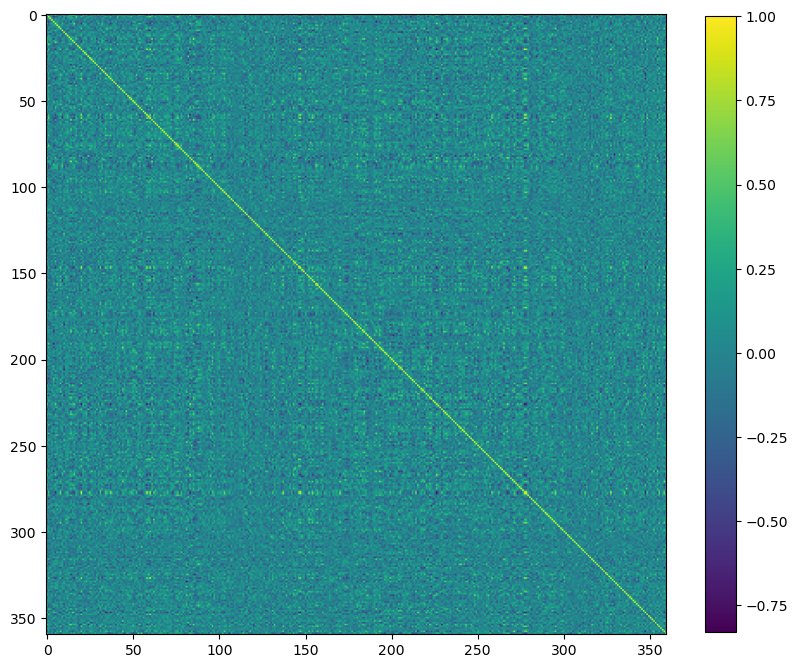

In [70]:
show_square(sim_cov)

In [292]:
# beta_test_name = 'all_unit_scale_short_reps_1000_steps_1200_inverse_cov_centered_target_0_beta_min_1e-09_max_0.01'
# beta_test_name = 'all_unit_scale_short_reps_1000_steps_1200_inverse_cov_centered_target_0_beta_min_1e-09_max_0.0002'
# beta_test_name = 'all_unit_scale_short_reps_1000_steps_12000_inverse_cov_centered_target_0_beta_min_1e-09_max_0.0002'
# beta_test_name = 'all_unit_scale_short_reps_1000_steps_1200_inverse_cov_centered_target_0_beta_min_1e-09_max_1'
beta_test_name = 'all_unit_scale_short_reps_1000_steps_1200_inverse_cov_uncentered_target_0_beta_min_1e-09_max_1'

In [293]:
beta = torch.load( os.path.join(file_dir, f'beta_{beta_test_name}.pt') )
print( beta.size() )

torch.Size([1000, 1])


In [294]:
flip_rate = torch.load( os.path.join(file_dir, f'flip_rate_{beta_test_name}.pt') )
print( flip_rate.size() )

torch.Size([1000, 1, 360])


In [295]:
fc_rmse = torch.load( os.path.join(file_dir, f'fc_rmse_{beta_test_name}.pt') )
print( fc_rmse.size() )

torch.Size([1000, 1])


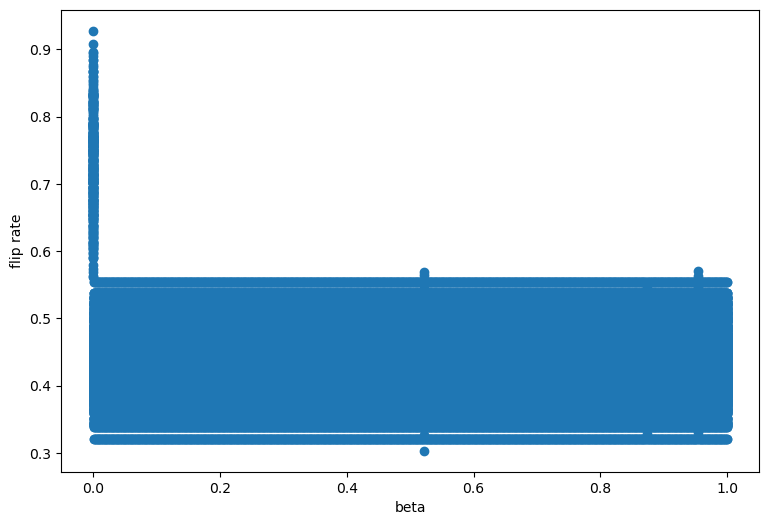

In [296]:
make_scatter(   xname='beta', xvalues=beta.unsqueeze(dim=-1).repeat(  ( 1,1,flip_rate.size(dim=-1) )  ).flatten(), yname='flip rate', yvalues=flip_rate.flatten()   )

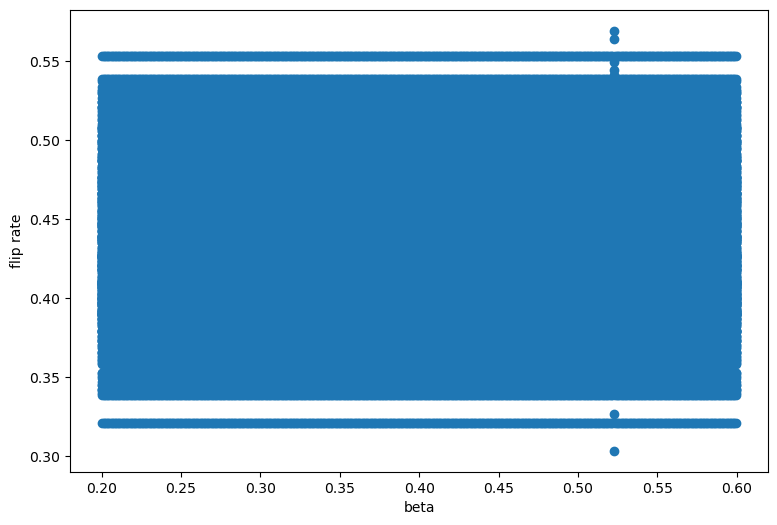

In [297]:
index_start = 200
index_end = 600
make_scatter(   xname='beta', xvalues=beta[index_start:index_end,:].unsqueeze(dim=-1).repeat(  ( 1,1,flip_rate.size(dim=-1) )  ).flatten(), yname='flip rate', yvalues=flip_rate[index_start:index_end,:,:].flatten()   )

In [298]:
flip_rate_var = flip_rate.var(dim=-1)
print( flip_rate_var.size() )

torch.Size([1000, 1])


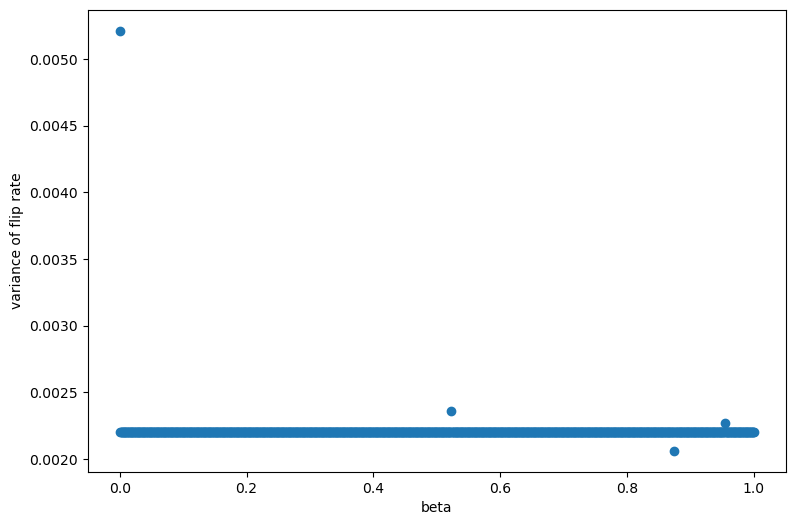

In [299]:
make_scatter( xname='beta', xvalues=beta.flatten(), yname='variance of flip rate', yvalues=flip_rate_var.flatten() )

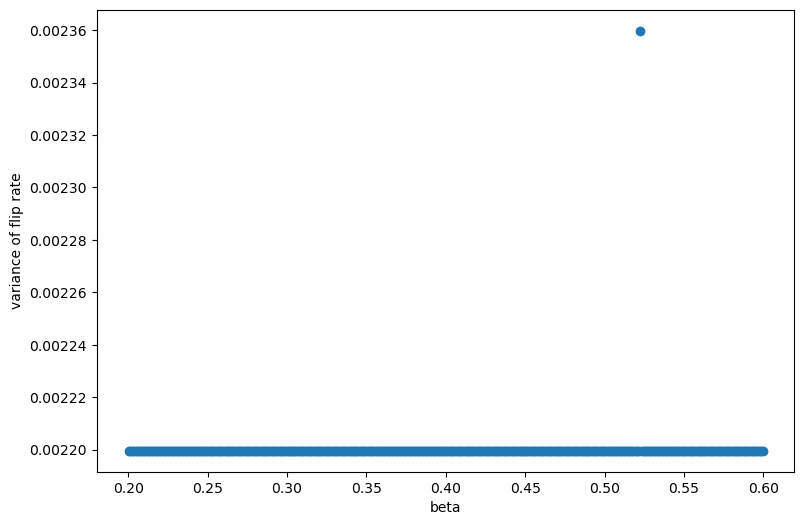

In [300]:
index_start = 200
index_end = 600
make_scatter( xname='beta', xvalues=beta.flatten()[index_start:index_end], yname='variance of flip rate', yvalues=flip_rate_var.flatten()[index_start:index_end] )

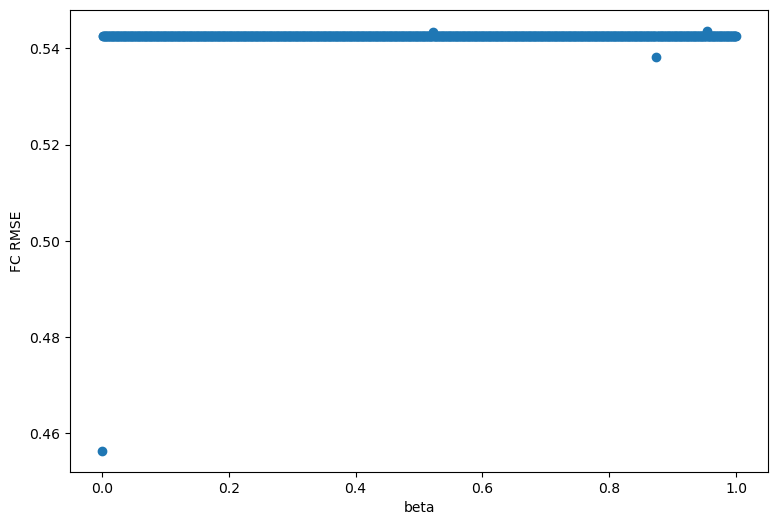

In [301]:
make_scatter( xname='beta', xvalues=beta.flatten(), yname='FC RMSE', yvalues=fc_rmse.flatten() )

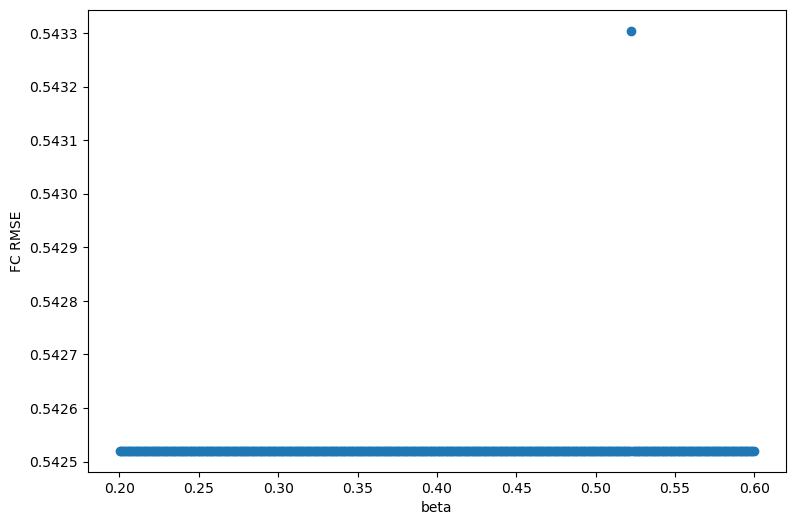

In [302]:
index_start = 200
index_end = 600
make_scatter( xname='beta', xvalues=beta.flatten()[index_start:index_end], yname='FC RMSE', yvalues=fc_rmse.flatten()[index_start:index_end] )

In [303]:
print( f'min FC RMSE {fc_rmse.min():.6g}' )
min_index = fc_rmse.argmin()
# print( min_index )
print( f'occurs at beta {beta.flatten()[min_index]:.6g}' )

min FC RMSE 0.456402
occurs at beta 1e-09


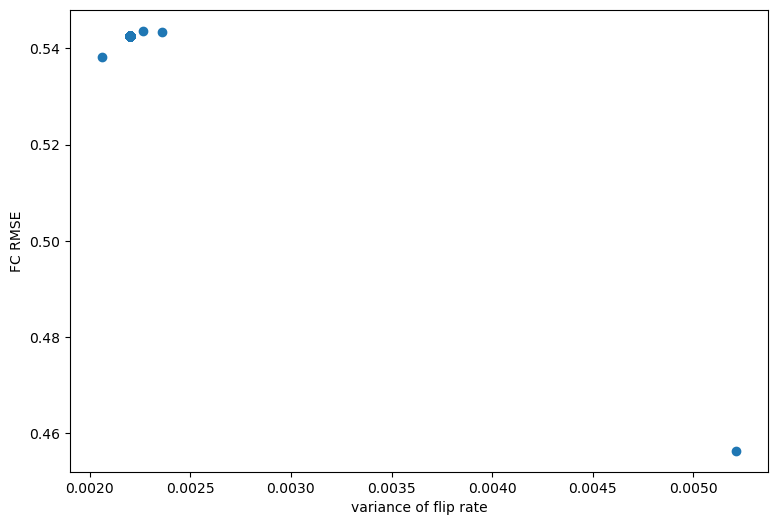

In [304]:
make_scatter( xname='variance of flip rate', xvalues=flip_rate_var.flatten(), yname='FC RMSE', yvalues=fc_rmse.flatten() )

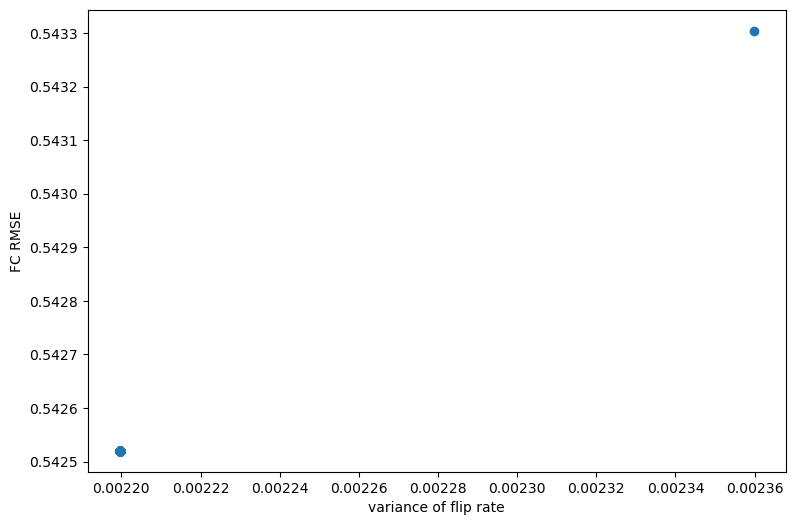

In [305]:
index_start = 200
index_end = 600
make_scatter( xname='variance of flip rate', xvalues=flip_rate_var[index_start:index_end].flatten(), yname='FC RMSE', yvalues=fc_rmse[index_start:index_end].flatten() )

In [174]:
multi_subject_test_name = 'all_unit_scale_short_reps_1_steps_1200_inverse_cov_centered_beta_0.0001'

In [175]:
subject_flip_rate = torch.load( os.path.join(file_dir, f'flip_rate_{multi_subject_test_name}.pt') )
print( subject_flip_rate.size() )

torch.Size([1, 3348, 360])


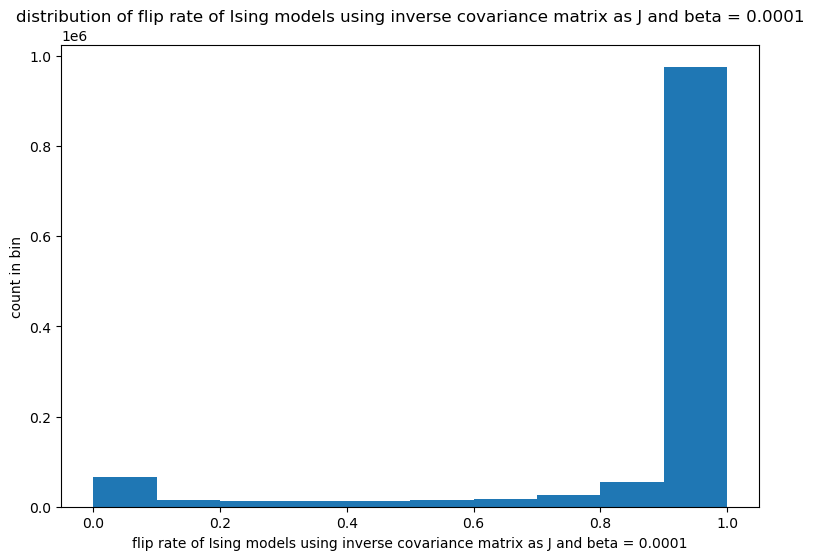

The distribution of flip rate of Ising models using inverse covariance matrix as J and beta = 0.0001 values has median 0.984 with 95% CI [0.00167, 0.999] and range [0, 1].


In [176]:
name = 'flip rate of Ising models using inverse covariance matrix as J and beta = 0.0001'
values = subject_flip_rate
make_histogram(name=name, values=values)
# print_stats_too_big(name=name, values=values)
print_stats(name=name, values=values)

In [158]:
subject_fc_rmse = torch.load( os.path.join(file_dir, f'fc_rmse_{multi_subject_test_name}.pt') )
print( subject_fc_rmse.size() )

torch.Size([1, 3348])


C:\Users\agcraig\Anaconda3\envs\torch_with_cuda\lib\site-packages\matplotlib\axes\_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\agcraig\Anaconda3\envs\torch_with_cuda\lib\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

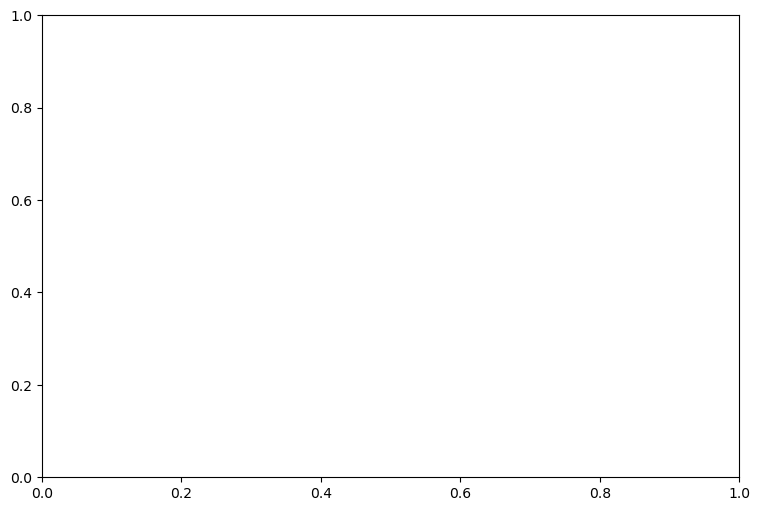

In [159]:
name = 'FC RMSE of Ising models using inverse covariance matrix as J and beta = 0.0001'
values = subject_fc_rmse
make_histogram(name=name, values=values)
# print_stats_too_big(name=name, values=values)
print_stats(name=name, values=values)

In [269]:
threshold_choices, std_flip_rates, mean_flip_rates, std_fc_rmse, mean_fc_rmse, std_fc_corr, mean_fc_corr = torch.load( os.path.join(file_dir, 'flip_rate_and_fc_rmse_summary_all_as_is_choices_1000_from_-5_to_5.pt') )

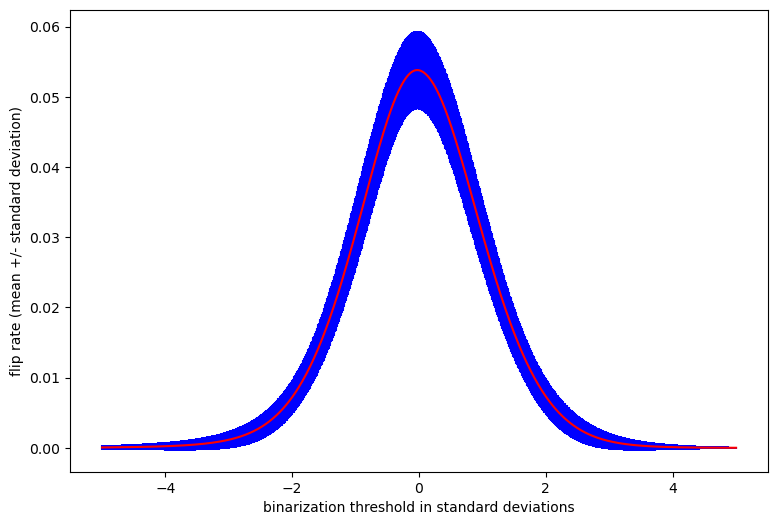

In [289]:
make_errorbar(xname='binarization threshold in standard deviations', xvalues=threshold_choices, yname='flip rate (mean +/- standard deviation)', yvalues=mean_flip_rates, yerrs=std_flip_rates)

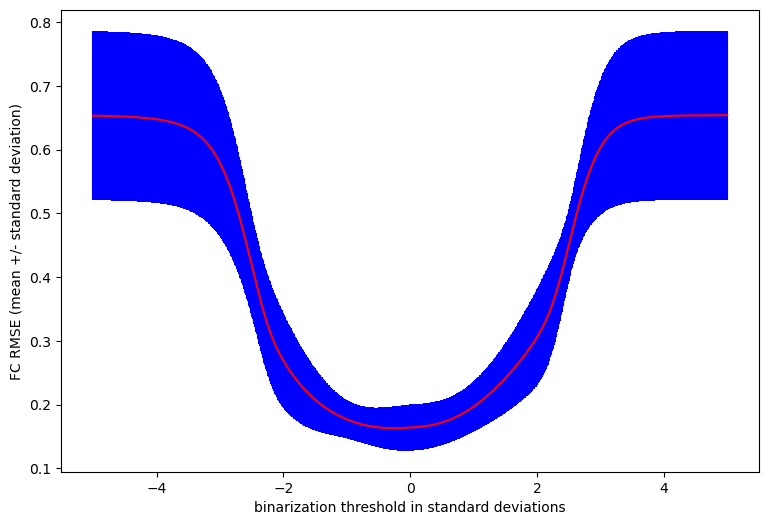

In [290]:
make_errorbar(xname='binarization threshold in standard deviations', xvalues=threshold_choices, yname='FC RMSE (mean +/- standard deviation)', yvalues=mean_fc_rmse, yerrs=std_fc_rmse)

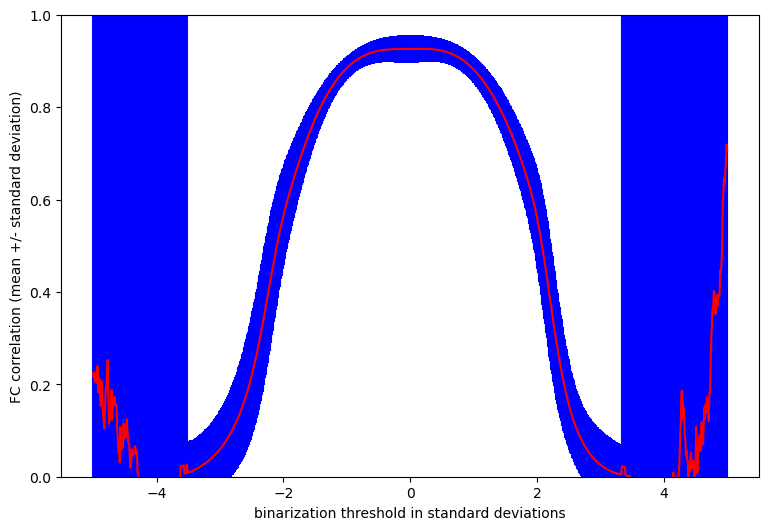

In [291]:
make_errorbar(xname='binarization threshold in standard deviations', xvalues=threshold_choices, yname='FC correlation (mean +/- standard deviation)', yvalues=mean_fc_corr, yerrs=std_fc_corr, y_bounds=[0, 1])

In [343]:
avalanche_counts = torch.load( os.path.join(file_dir, 'avalanche_counts_all_as_is_choices_100_from_-5_to_5.pt') )
print( avalanche_counts.size() )

torch.Size([100, 361])


In [344]:
avalanche_counts_total = avalanche_counts.sum(dim=0)
avalanche_counts_gt_0 = avalanche_counts_total > 0
num_avalanche_counts = torch.count_nonzero(avalanche_counts_gt_0)
print(f'Only {num_avalanche_counts} distinct avalanche sizes occur.')

Only 353 distinct avalanche sizes occur.


In [345]:
step_counts = avalanche_counts.sum(dim=-1, keepdim=True)
avalanche_probs = avalanche_counts/step_counts

In [355]:
min_threshold = -5
max_threshold = 5
num_thresholds = avalanche_probs.size(dim=0)
thresholds = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=float_type, device=device)
print( thresholds.size() )

torch.Size([100])


Text(0.5, 1.0, 'P(N flips in a single time step) for different binarizing thresholds')

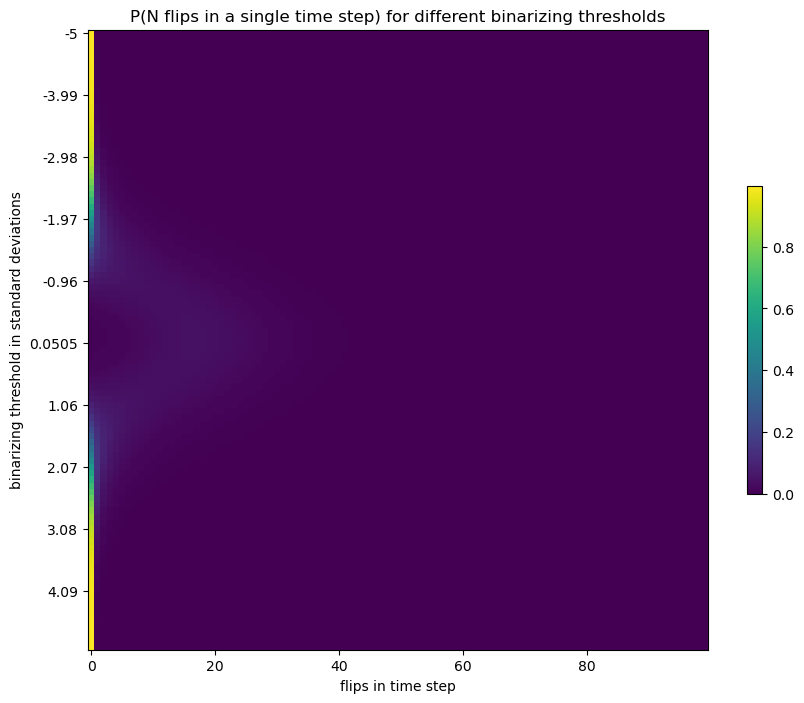

In [369]:
max_size = 100
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(10, 10) )
cbax = axs.imshow( depytorch(avalanche_probs[:,:max_size]) )
fig.colorbar(cbax, shrink=0.4)
y_tick_indices = np.arange(0, num_thresholds, 10)
axs.set_yticks(y_tick_indices)
axs.set_yticklabels([ f'{tickl:.3g}' for tickl in thresholds[y_tick_indices] ])# , rotation=90, ha='right'
axs.set_xlabel('flips in time step')
axs.set_ylabel('binarizing threshold in standard deviations')
axs.set_title('P(N flips in a single time step) for different binarizing thresholds')

In [371]:
avalanche_counts_median = torch.load( os.path.join(file_dir, 'avalanche_counts_all_as_is_binarized_median.pt') )
print( avalanche_counts_median.size() )
avalanche_probs_median = avalanche_counts_median/avalanche_counts_median.sum()

torch.Size([361])


Text(0.5, 1.0, 'log2( P(N flips in a single time step) ) for different binarizing thresholds')

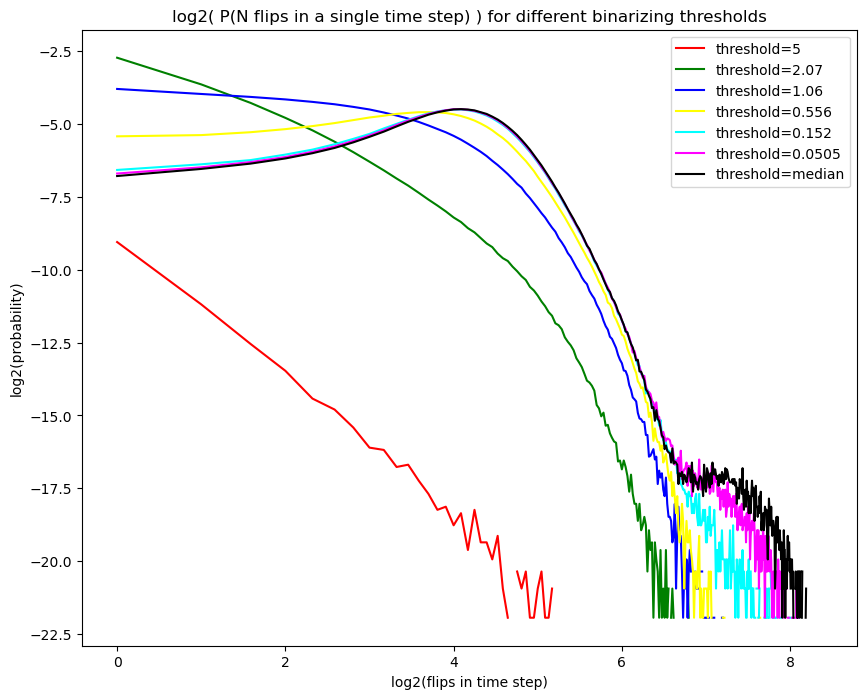

In [387]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(10, 8) )
avalanche_sizes = depytorch(  torch.arange( avalanche_probs.size(dim=-1) ).log2()  )
colors = ['red', 'green', 'blue', 'yellow', 'cyan', 'magenta']
selected_threshold_indices = [99, 70, 60, 55, 51, 50]
for index in range( len(selected_threshold_indices) ):
    threshold_index = selected_threshold_indices[index]
    axs.plot(  avalanche_sizes, depytorch( avalanche_probs[threshold_index,:].log2() ), color=colors[index], label=f'threshold={thresholds[threshold_index]:.3g}'  )
axs.plot(  avalanche_sizes, depytorch( avalanche_probs_median.log2() ), color='black', label=f'threshold=median'  )
# axs.set_xlim([0, 125])
axs.legend()
axs.set_xlabel('log2(flips in time step)')
axs.set_ylabel('log2(probability)')
axs.set_title('log2( P(N flips in a single time step) ) for different binarizing thresholds')

In [376]:
flip_count = torch.load( os.path.join(file_dir, 'flip_count_sim_length_1200_group_training_and_individual_all_fold_1_betas_5_steps_1200_lr_0.01_h_no.pt') )
print( flip_count.size() )
flip_rate = flip_count/(1200-1)

torch.Size([4190, 360])


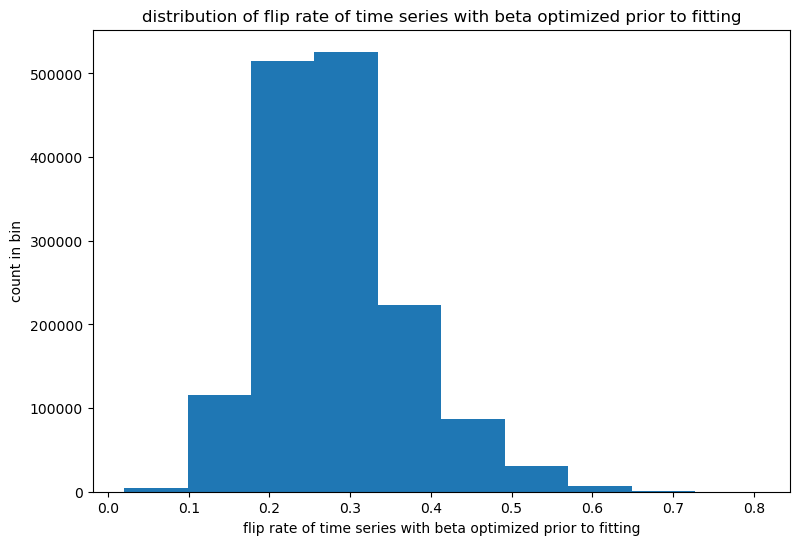

The distribution of flip rate of time series with beta optimized prior to fitting values has median 0.27 with 95% CI [0.144, 0.492] and range [0.02, 0.806].


In [377]:
name = 'flip rate of time series with beta optimized prior to fitting'
values = flip_rate
make_histogram(name=name, values=values)
# print_stats_too_big(name=name, values=values)
print_stats(name=name, values=values)

torch.Size([4190, 360])


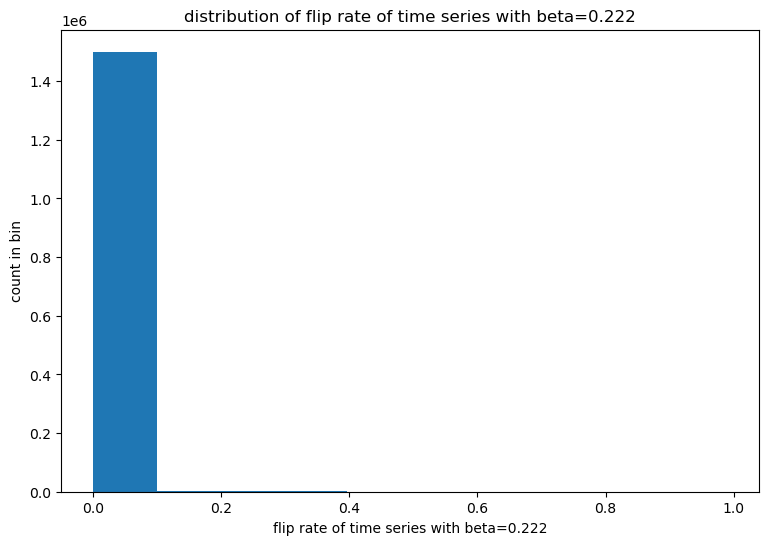

The distribution of flip rate of time series with beta=0.222 values has median 0 with 95% CI [0, 0] and range [0, 0.99].


In [385]:
num_beta = 10
min_beta = 0
max_beta = 1
beta_choices = torch.linspace(start=min_beta, end=max_beta, steps=num_beta, dtype=float_type, device=device)
beta = beta_choices[2]
flip_count_for_beta = torch.load( os.path.join(file_dir, f'flip_count_sim_length_1200_group_training_and_individual_all_fold_1_betas_5_steps_1200_lr_0.01_h_no_beta_{beta:.3g}.pt') )
print( flip_count_for_beta.size() )
flip_rate_for_beta = flip_count_for_beta/(1200-1)
name = f'flip rate of time series with beta={beta:.3g}'
values = flip_rate_for_beta
make_histogram(name=name, values=values)
# print_stats_too_big(name=name, values=values)
print_stats(name=name, values=values)

In [12]:
# test_beta = torch.linspace( start=0, end=1, steps=5, dtype=float_type, device=device ).unsqueeze(dim=1).repeat( (1,9) )
test_beta = torch.randn( (5,8), dtype=float_type, device=device )
print(test_beta)

tensor([[-0.3409, -0.6731, -1.1612, -0.0724,  0.4146,  0.4264,  1.2884,  0.0383],
        [-0.7558,  0.2022, -0.6642, -1.1855, -1.4122, -1.2705, -0.2488, -0.1552],
        [ 0.6898,  1.3165,  0.6761,  0.7751,  0.7129,  0.4938, -1.3002, -0.6720],
        [-0.1239, -1.6615,  1.2493,  1.0985,  1.1447, -1.1600,  1.4829,  0.9419],
        [-2.1435, -0.6962, -0.8263,  0.4933,  1.1267,  0.3976, -0.7126, -0.0816]],
       device='cuda:0')


In [13]:
test_best_indices = torch.randint( high=5, size=(8,), dtype=int_type, device=device )
print(test_best_indices)

tensor([2, 0, 2, 4, 0, 4, 2, 2], device='cuda:0', dtype=torch.int32)


In [14]:
col_indices = torch.arange(8, dtype=int_type, device=device)
test_best_beta = test_beta[test_best_indices,col_indices]
print(test_best_beta)

tensor([ 0.6898, -0.6731,  0.6761,  0.4933,  0.4146,  0.3976, -1.3002, -0.6720],
       device='cuda:0')


In [15]:
data_mean_state_product_file = os.path.join(file_dir, 'mean_state_product_all_quantile_0.5.pt')
data_mean_state_product = torch.load(data_mean_state_product_file)[:,training_index_start:training_index_end,:]
print( data_mean_state_product.size() )

torch.Size([4, 669, 360, 360])


In [17]:
data_mean_state_product = isingmodellight.square_to_triu_pairs(square_pairs=data_mean_state_product)
print( data_mean_state_product.size() )

torch.Size([4, 669, 64620])


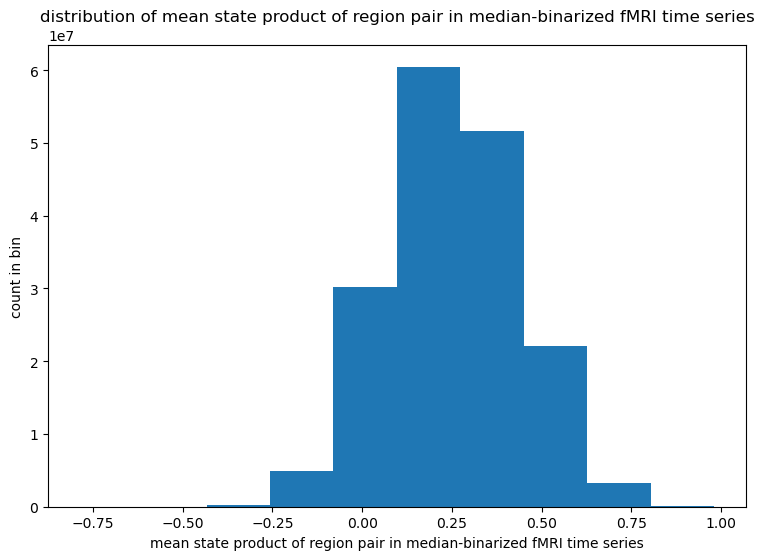

lower quantile 4323078, -1 and +1 tensor(-0.0933, device='cuda:0') tensor(-0.0933, device='cuda:0') tensor(-0.0933, device='cuda:0')
half way point 86461560, -1 and +1 tensor(0.2467, device='cuda:0') tensor(0.2467, device='cuda:0') tensor(0.2467, device='cuda:0')
upper quantile 168600042, -1 and +1 tensor(0.6100, device='cuda:0') tensor(0.6100, device='cuda:0') tensor(0.6100, device='cuda:0')
The distribution of mean state product of region pair in median-binarized fMRI time series values has median 0.247 with 95% CI [-0.0933, 0.61] and range [-0.787, 0.98].


In [19]:
name = 'mean state product of region pair in median-binarized fMRI time series'
values = data_mean_state_product
make_histogram(name=name, values=values)
print_stats_too_big(name=name, values=values)